In [1]:
import matplotlib
import matplotlib.pyplot as plt
from matplotlib.ticker import FormatStrFormatter
import matplotlib.patches as mpatches
import matplotlib.gridspec as gridspec
import numpy as np
from pyuvdata import UVCal, UVData, UVFlag
import os
import sys
import glob
import uvtools as uvt
from astropy.time import Time
from astropy.coordinates import EarthLocation, SkyCoord, AltAz, Angle
import pandas
import warnings 
import copy
from hera_notebook_templates import utils
import hera_qm
from hera_mc import cm_hookup
import h5py
import importlib
from scipy import stats
import scipy
#warnings.filterwarnings('ignore')

%matplotlib inline
%config InlineBackend.figure_format = 'retina'


In [2]:
#get data location
JD = os.environ['JULIANDATE']
data_path = os.environ['DATA_PATH']
utc = Time(JD, format='jd').datetime
print(f'JD = {JD}')
print(f'Date = {utc.month}-{utc.day}-{utc.year}')
print(f'data_path = "{data_path}"')

JD = 2459241
Date = 1-26-2021
data_path = "/mnt/sn1"


In [3]:
# Load in data
HHfiles, difffiles, HHautos, diffautos, uvdx, uvdy = utils.load_data(data_path,JD)
    
uvd = UVData()
uvd_diff = UVData()
unread = True
i=0
while unread and i<len(HHautos):
    try:
        uvd.read(HHautos[i])
        unread = False
    except:
        i += 1
        continue
use_ants = [int(ant) for ant in uvd.get_ants()]
bls = [(ant, ant) for ant in use_ants]
uvd.read(HHfiles[::10], skip_bad_files=True, bls=bls)
uvd_diff.read(difffiles[::10], skip_bad_files=True, bls=bls)
lsts = uvd.lst_array

flagfile = glob.glob(os.path.join(HHfiles[0].split('zen')[0],'*total_stage_1_threshold_flags.h5'))    
uvf = UVFlag()
uvf.read(flagfile)
bls = [(ant, ant) for ant in uvd.get_ants()]
times_uvf = np.unique(uvf.time_array)
times_uvd = np.unique(uvd.time_array)
idx_times = [np.where(time_uvd == times_uvf)[0][0] for time_uvd in times_uvd]
uvd.flag_array[:,0,:,:] = np.repeat(uvf.flag_array[idx_times], len(bls), axis=0)

600 sum files found between JDs 2459241.49564 and 2459241.61475
600 diff files found between JDs 2459241.49564 and 2459241.61475
600 sum auto files found between JDs 2459241.49564 and 2459241.61475
600 diff auto files found between JDs 2459241.49564 and 2459241.61475


## LST Coverage

Shows the LSTs (in hours) and JDs for which data is collected. Green represents data, red means no data.

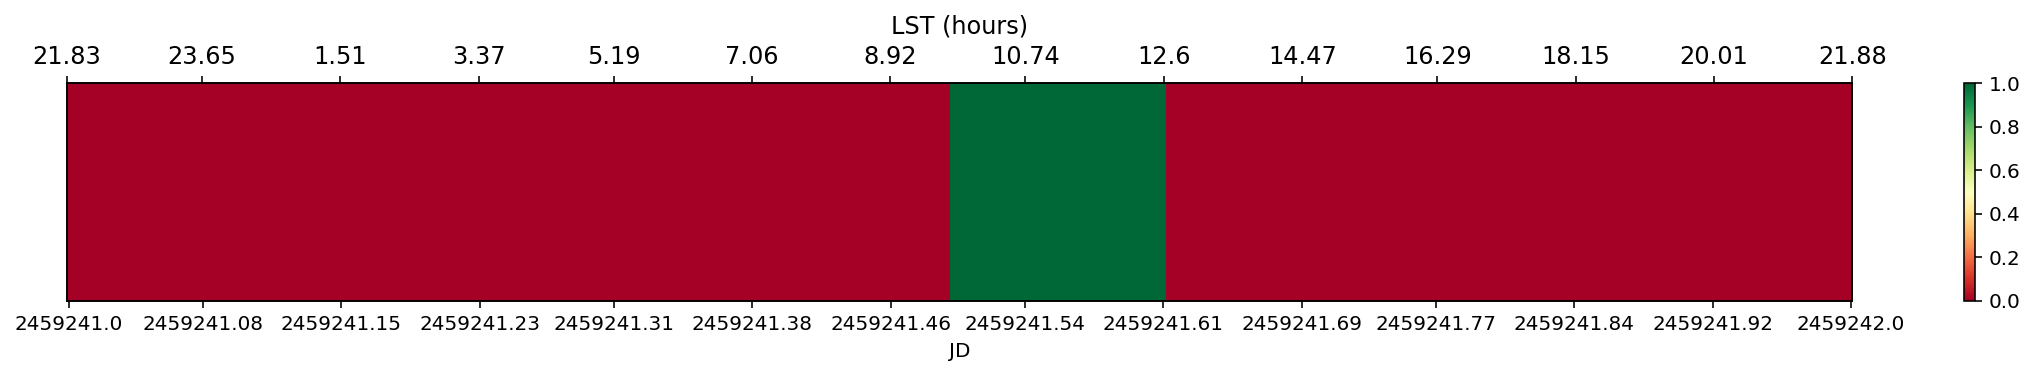

In [4]:
utils.plot_lst_coverage(uvd)

## Delay spectrum

Delay spectrum CLEANed using uvtools.dspec.high_pass_fourier_filter with 7th-order Blackman-Harris window function. Odd/even visibilities are used to remove noise bias.

In [5]:
_data_cleaned_sq, data_rs_sq = utils.clean_ds(HHfiles[::10], bls, uvd, uvd_diff)

## Waterfalls of delay spectra for autocorrelation

These plots show autocorrelation delay spectrum waterfalls of each antenna that is active and whose status qualifies for this notebook. For each node, antennas are ordered by SNAP number, and within that by SNAP input number. The antenna number label color corresponds to the a priori status of that antenna.

### nn polarization

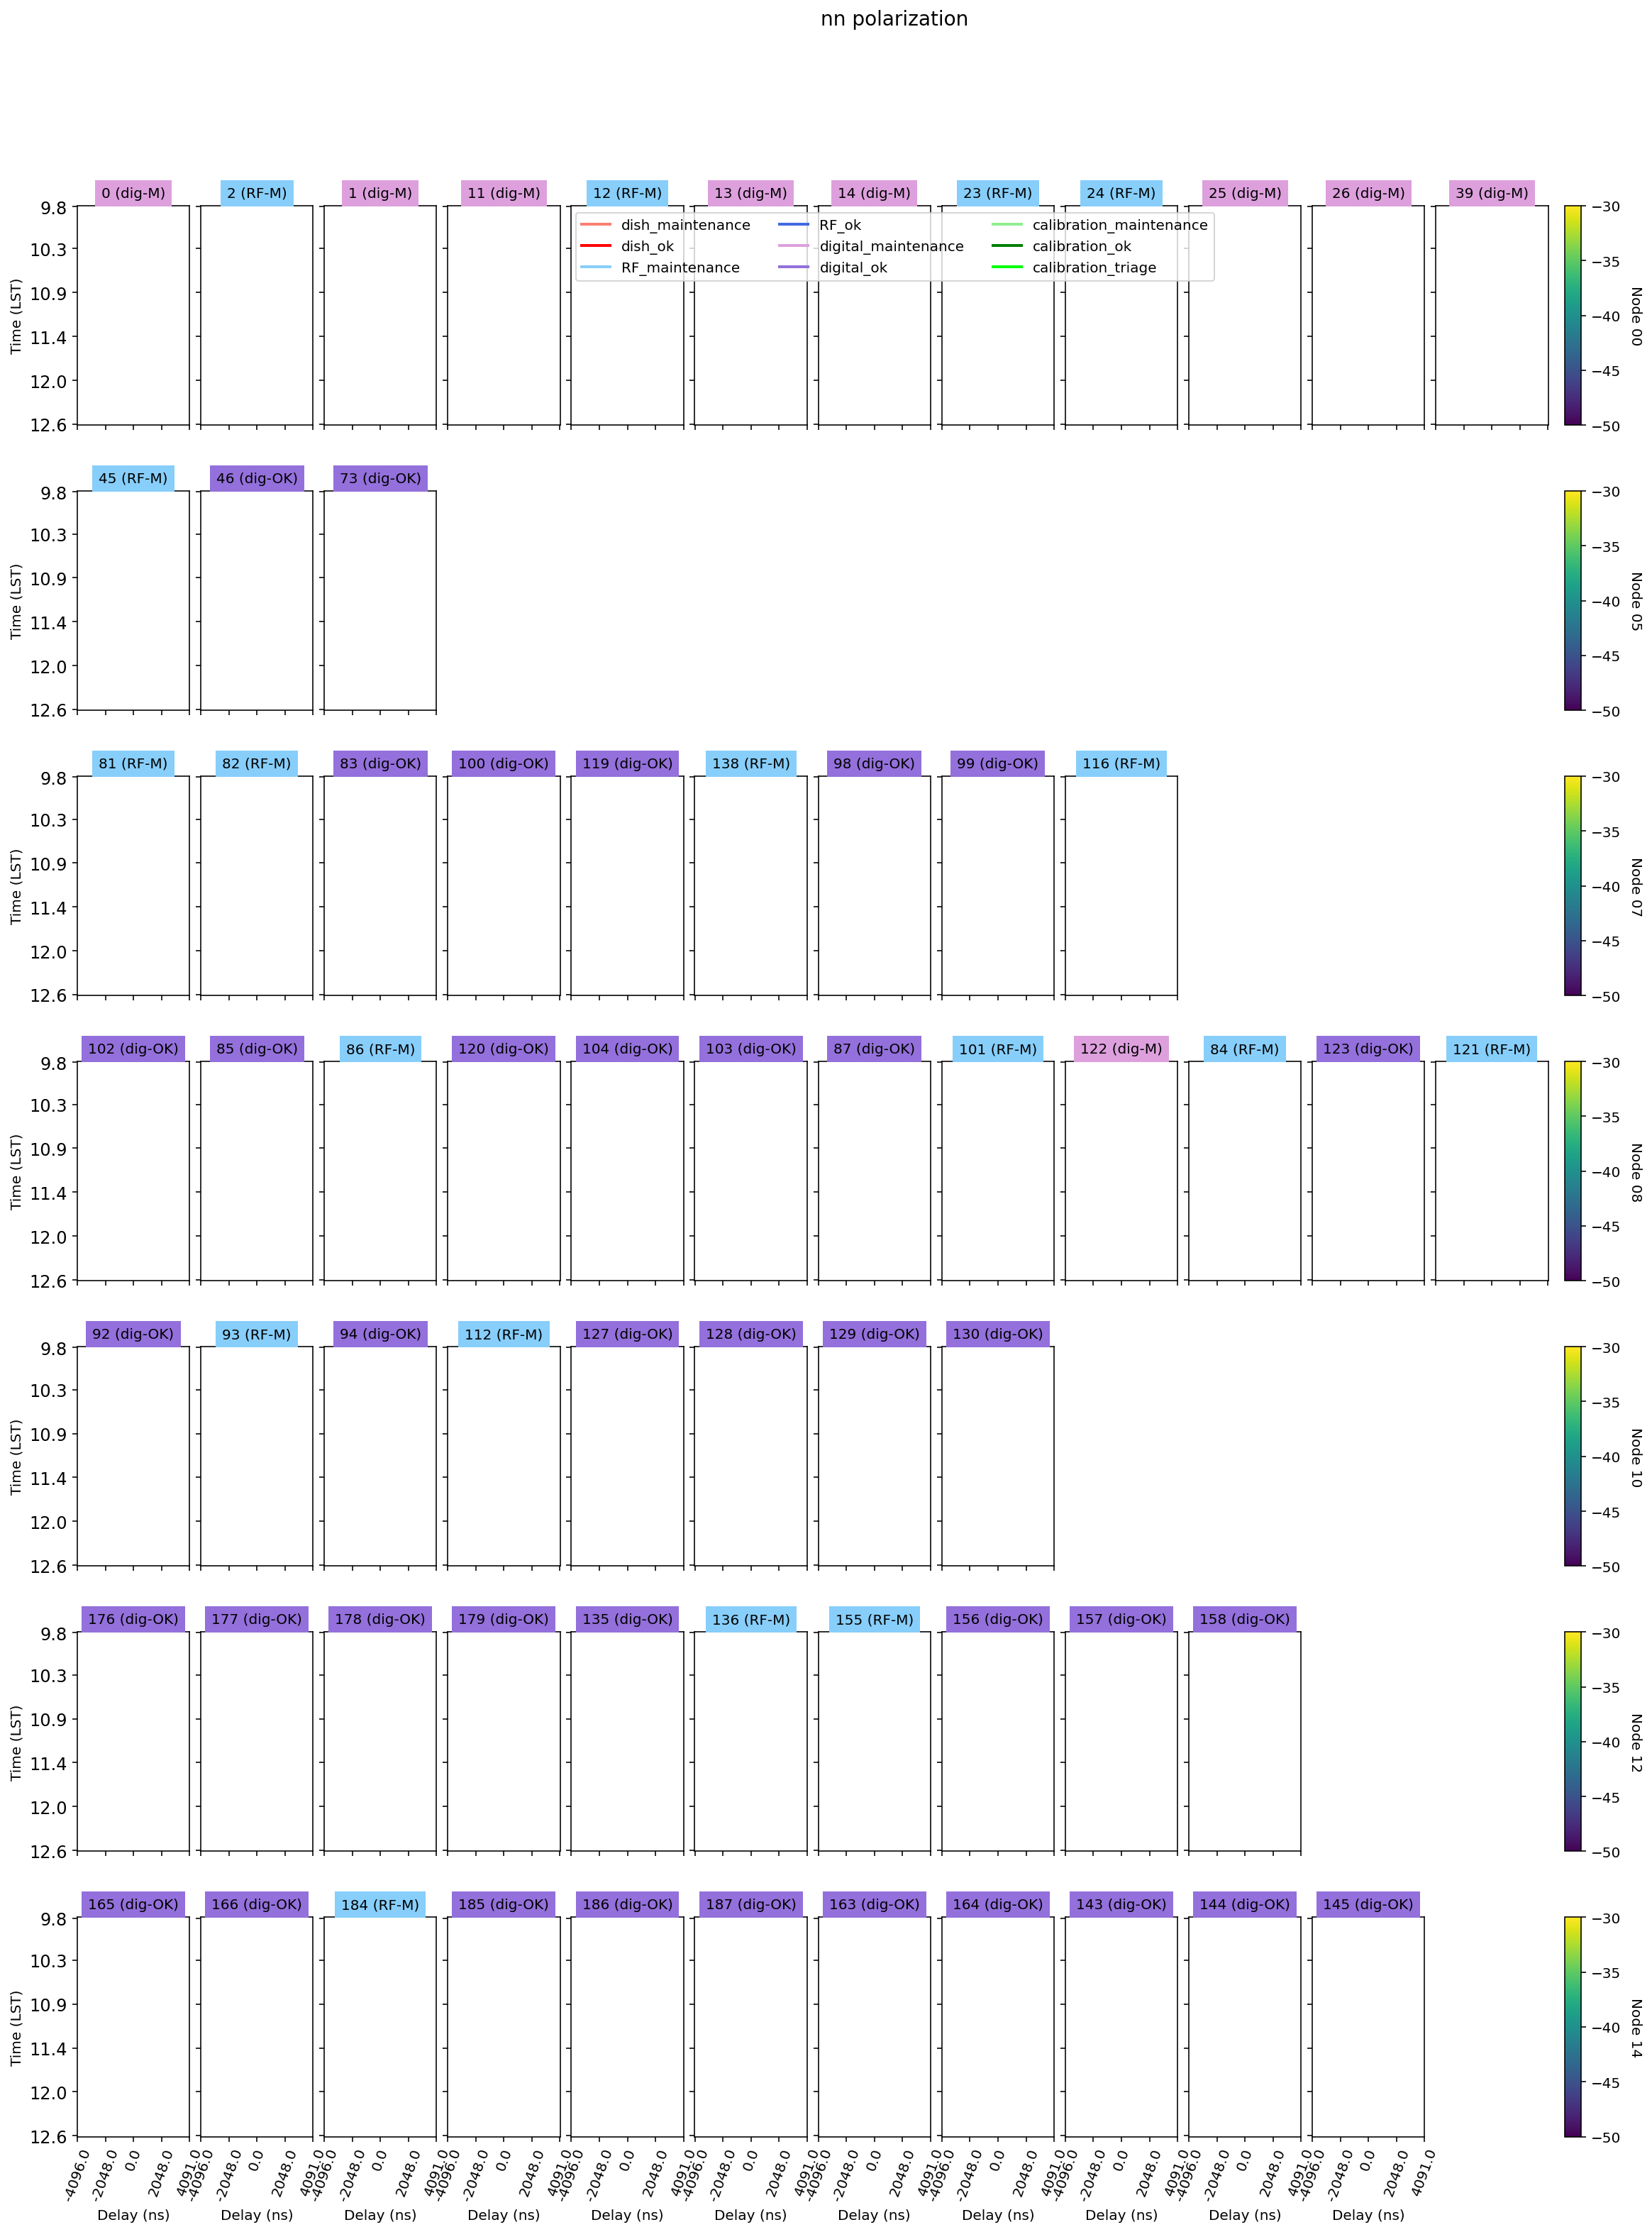

In [6]:
utils.plot_wfds(uvd, _data_cleaned_sq, 0)

### ee polarization

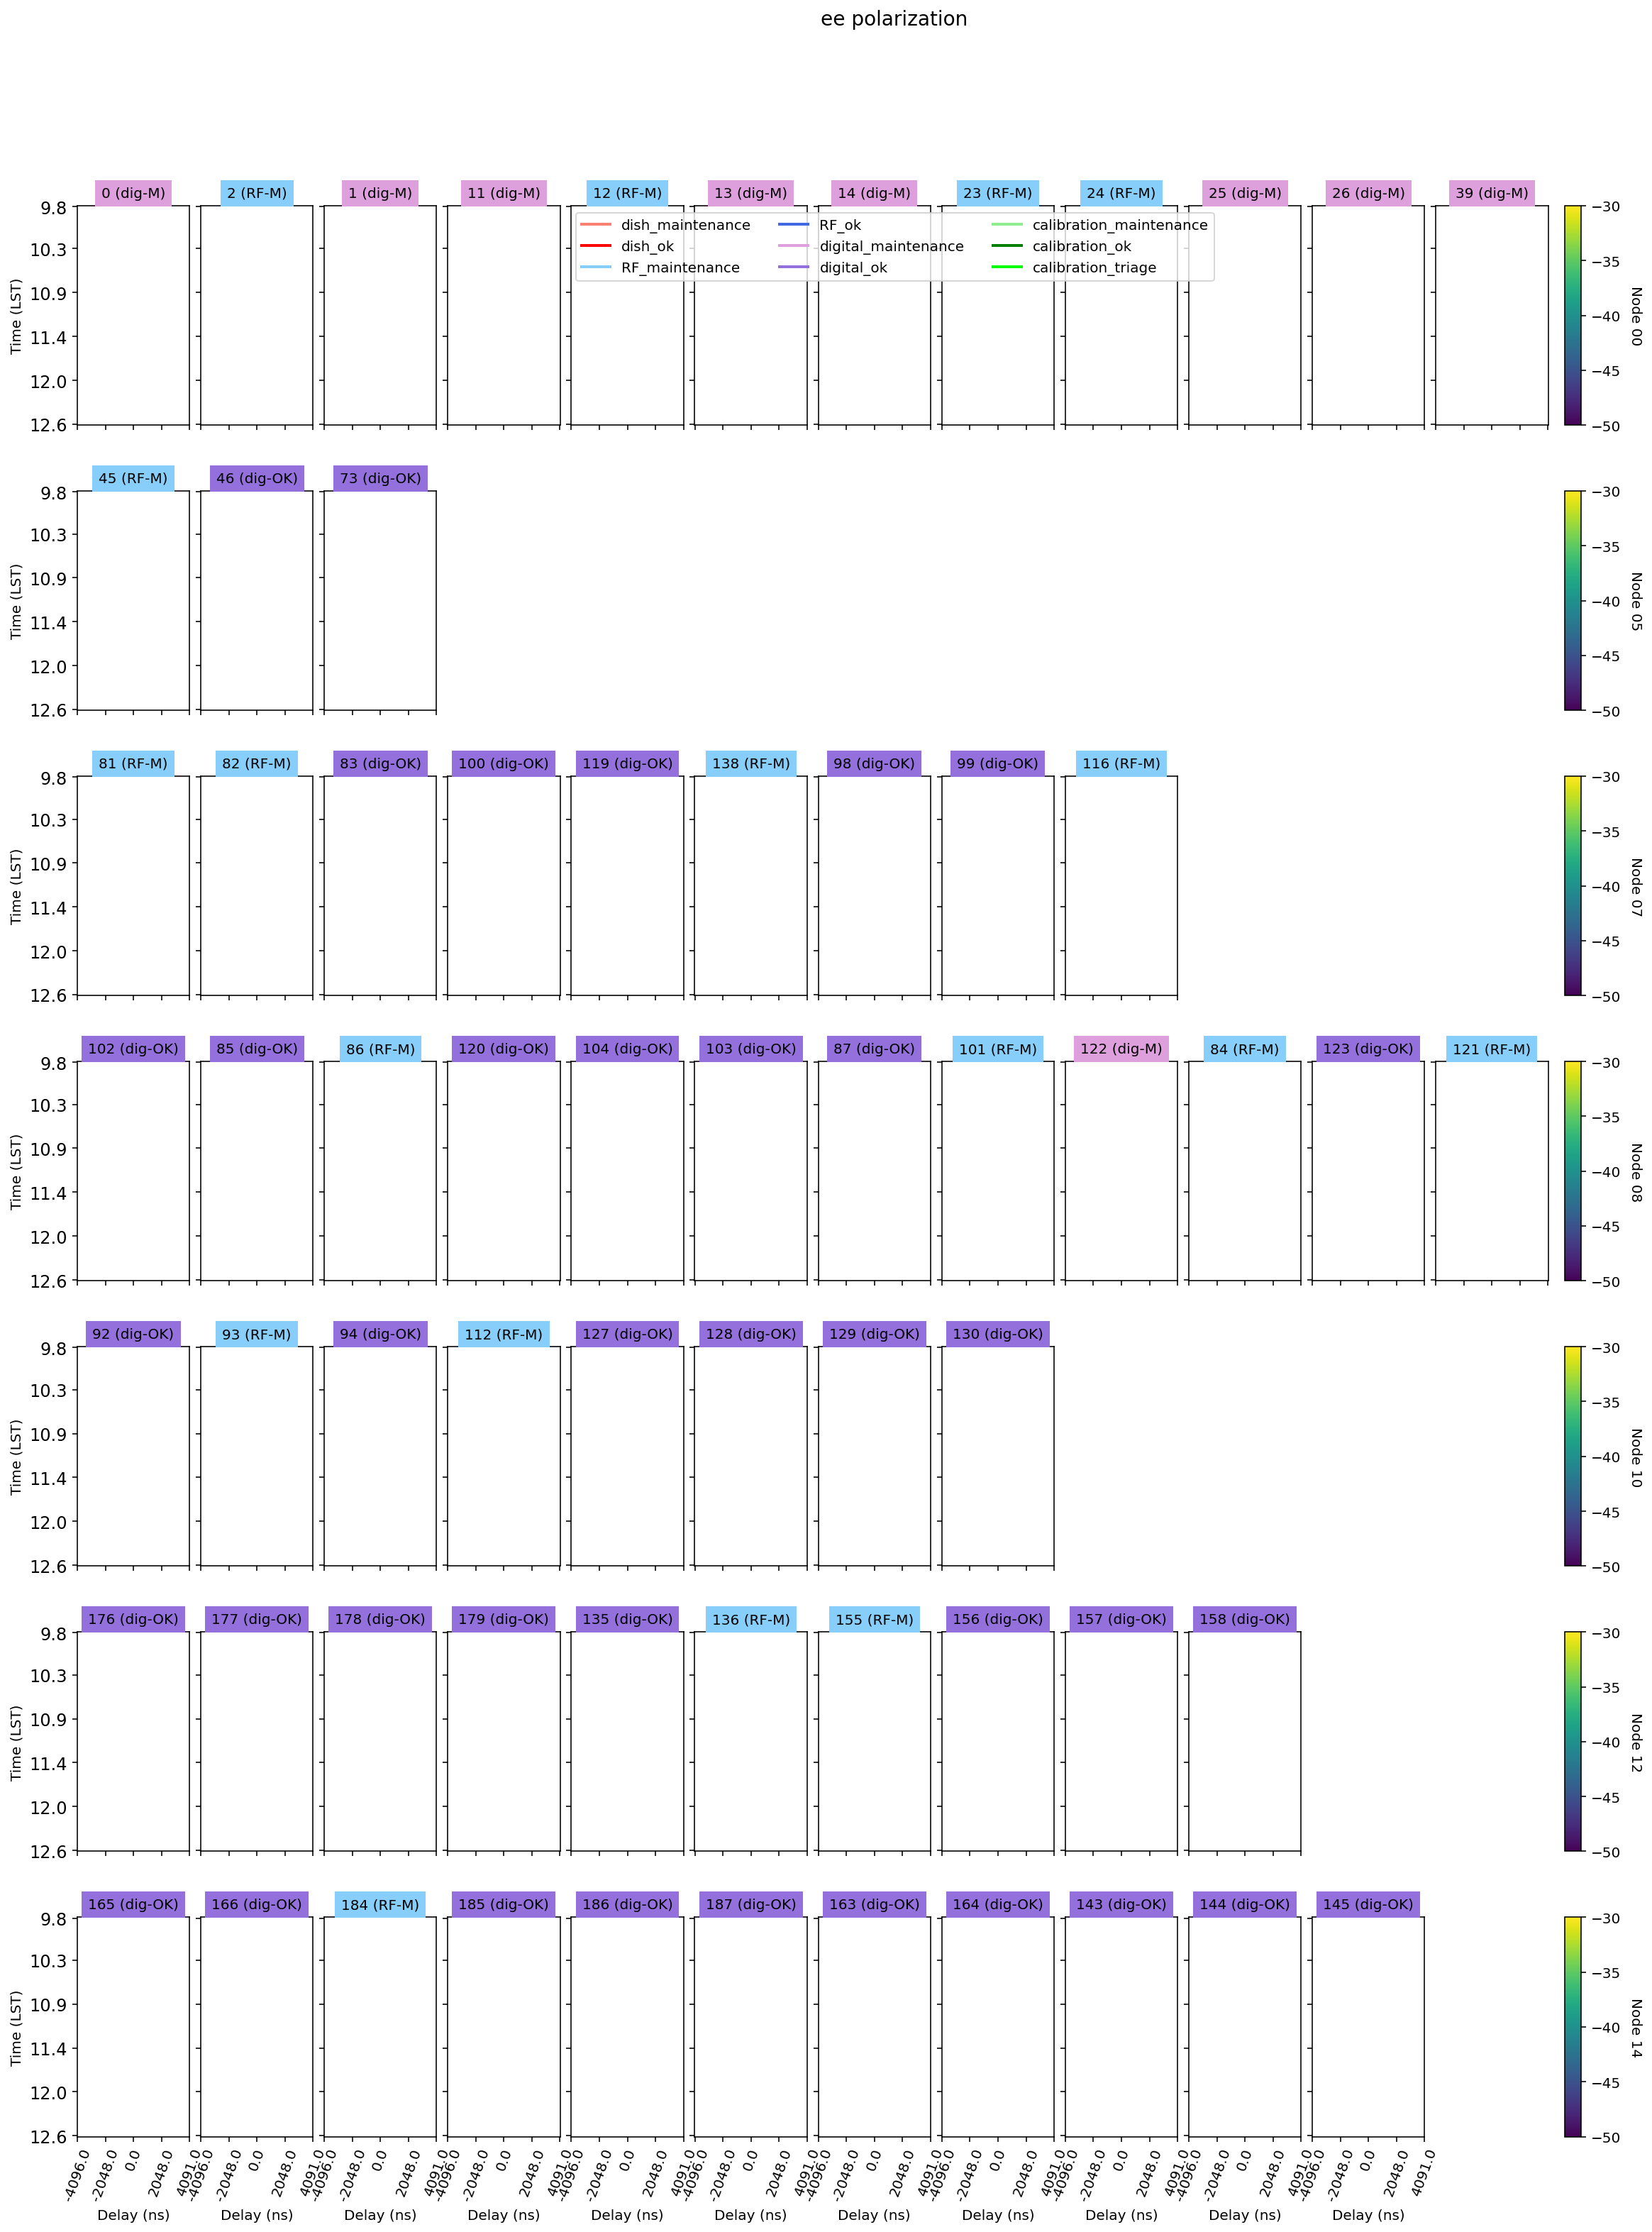

In [7]:
utils.plot_wfds(uvd, _data_cleaned_sq, 1)

### ne polarization

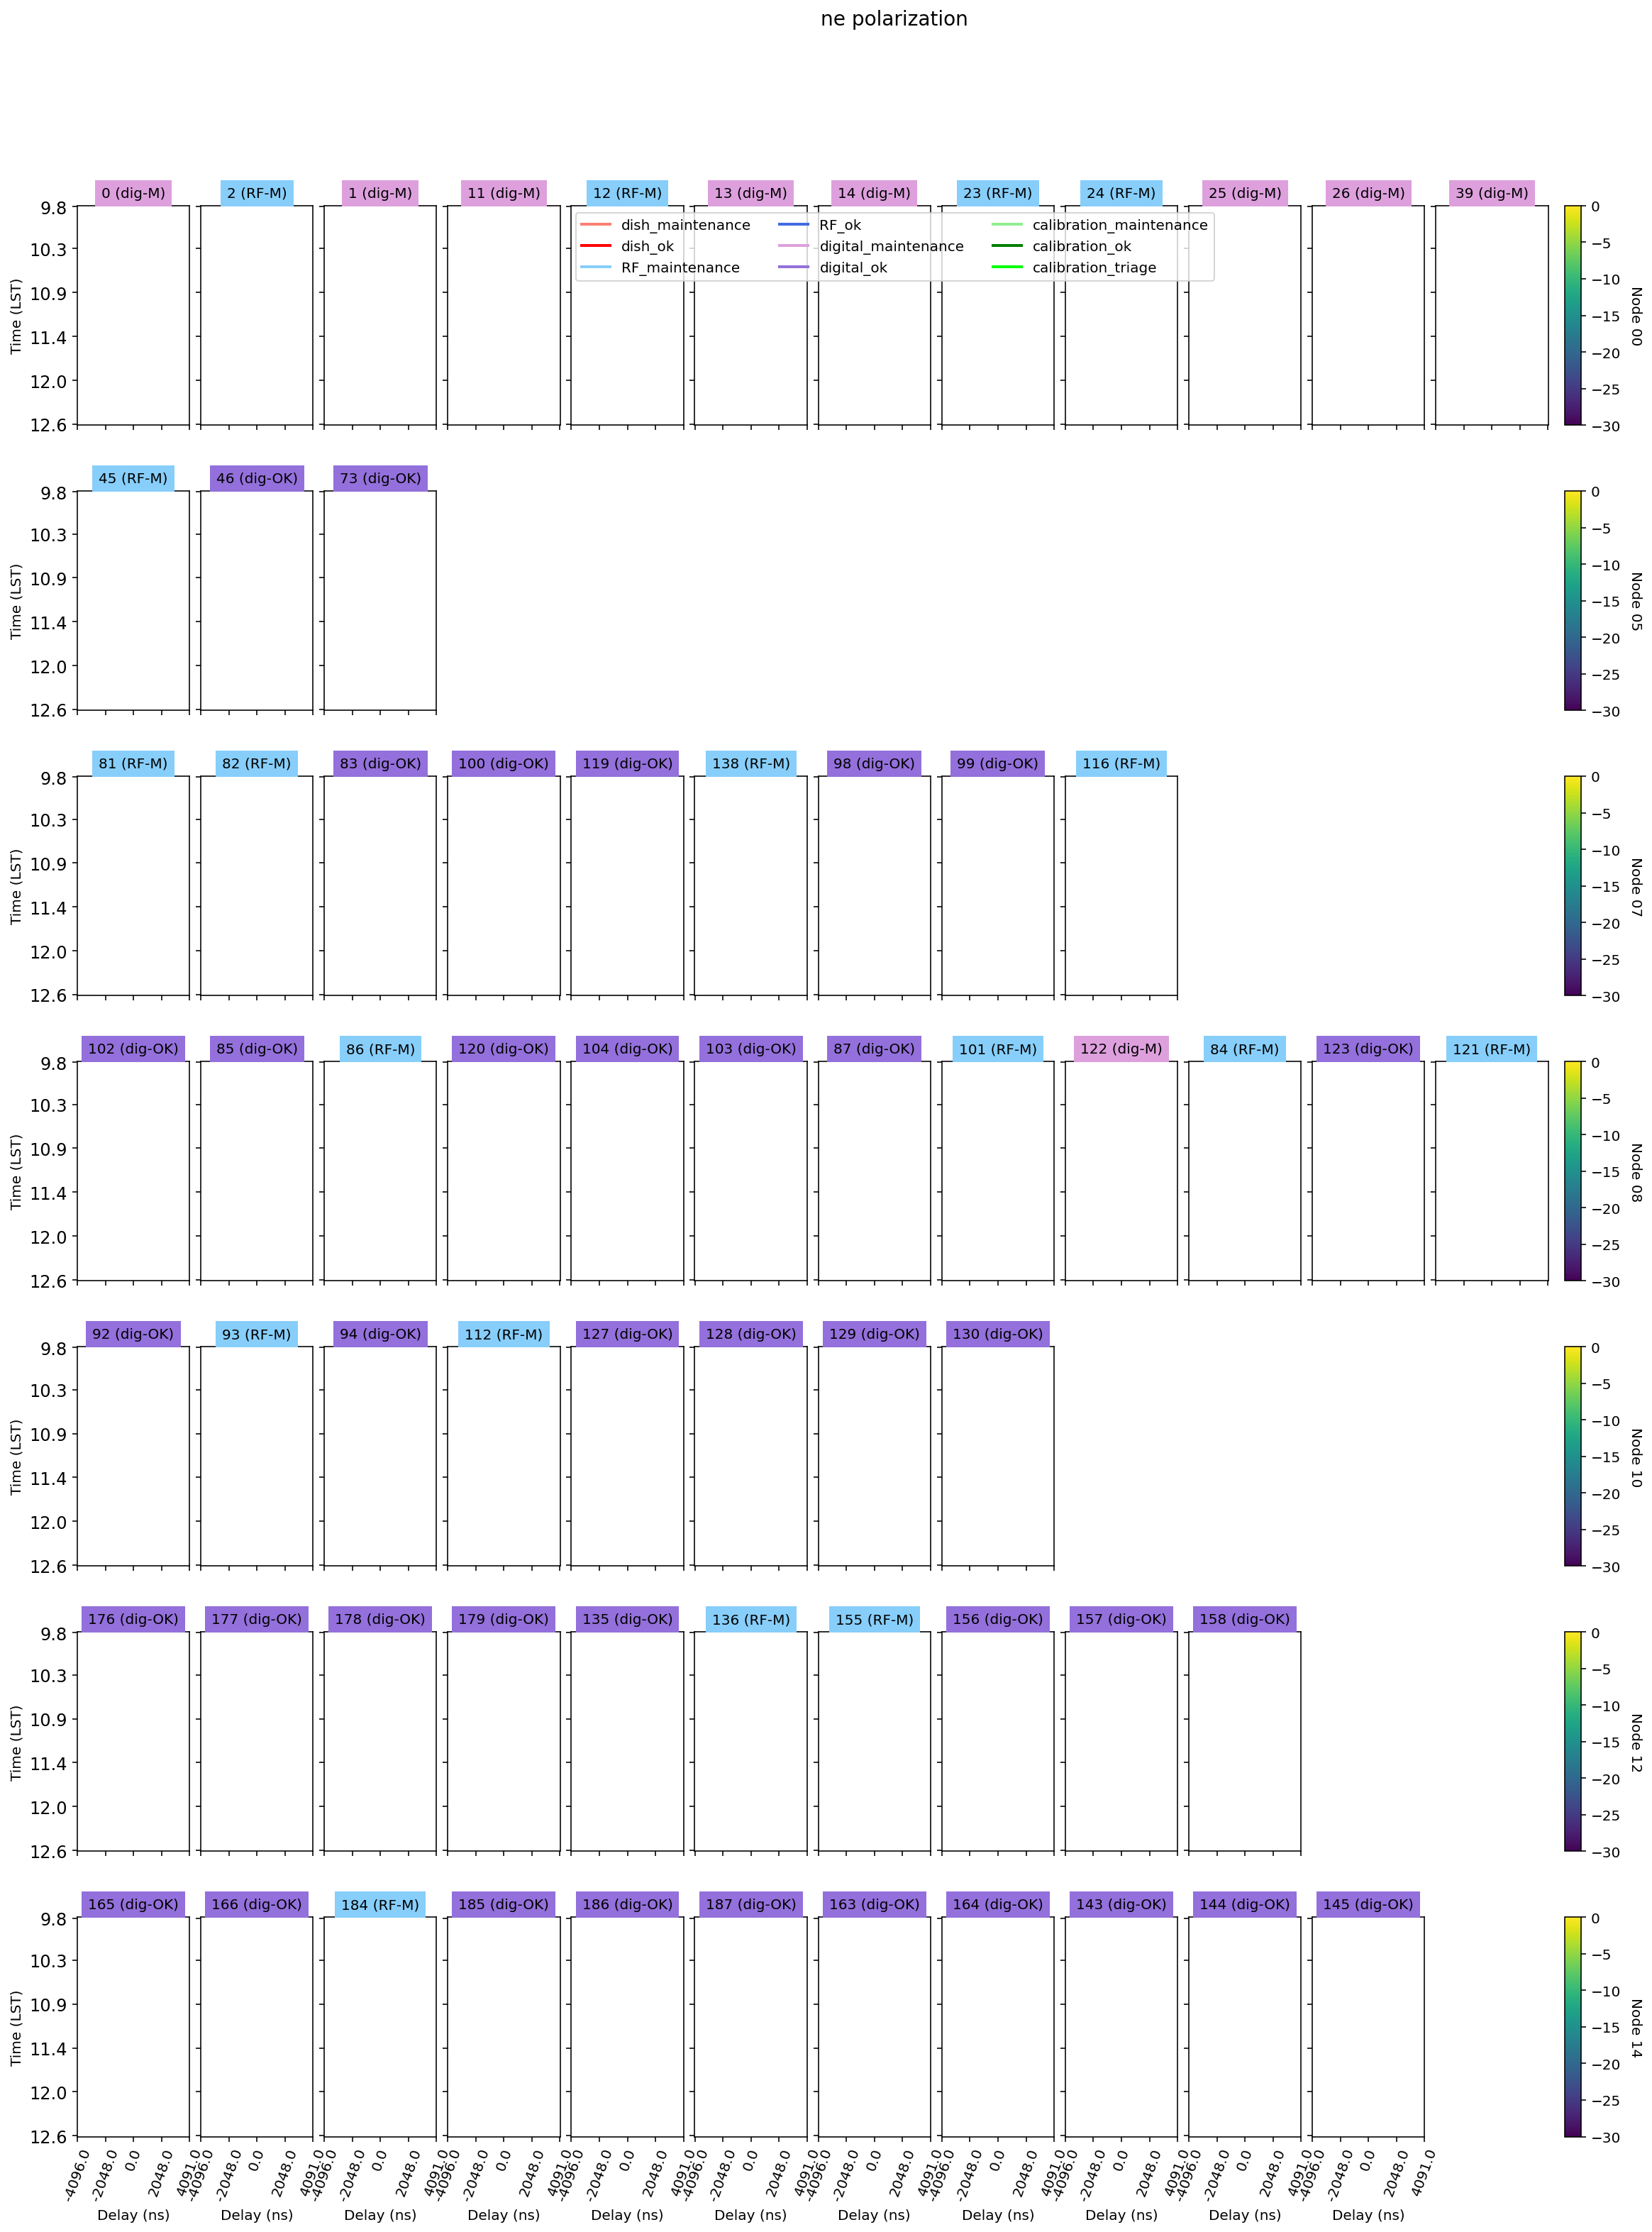

In [8]:
utils.plot_wfds(uvd, _data_cleaned_sq, 2)

### en polarization

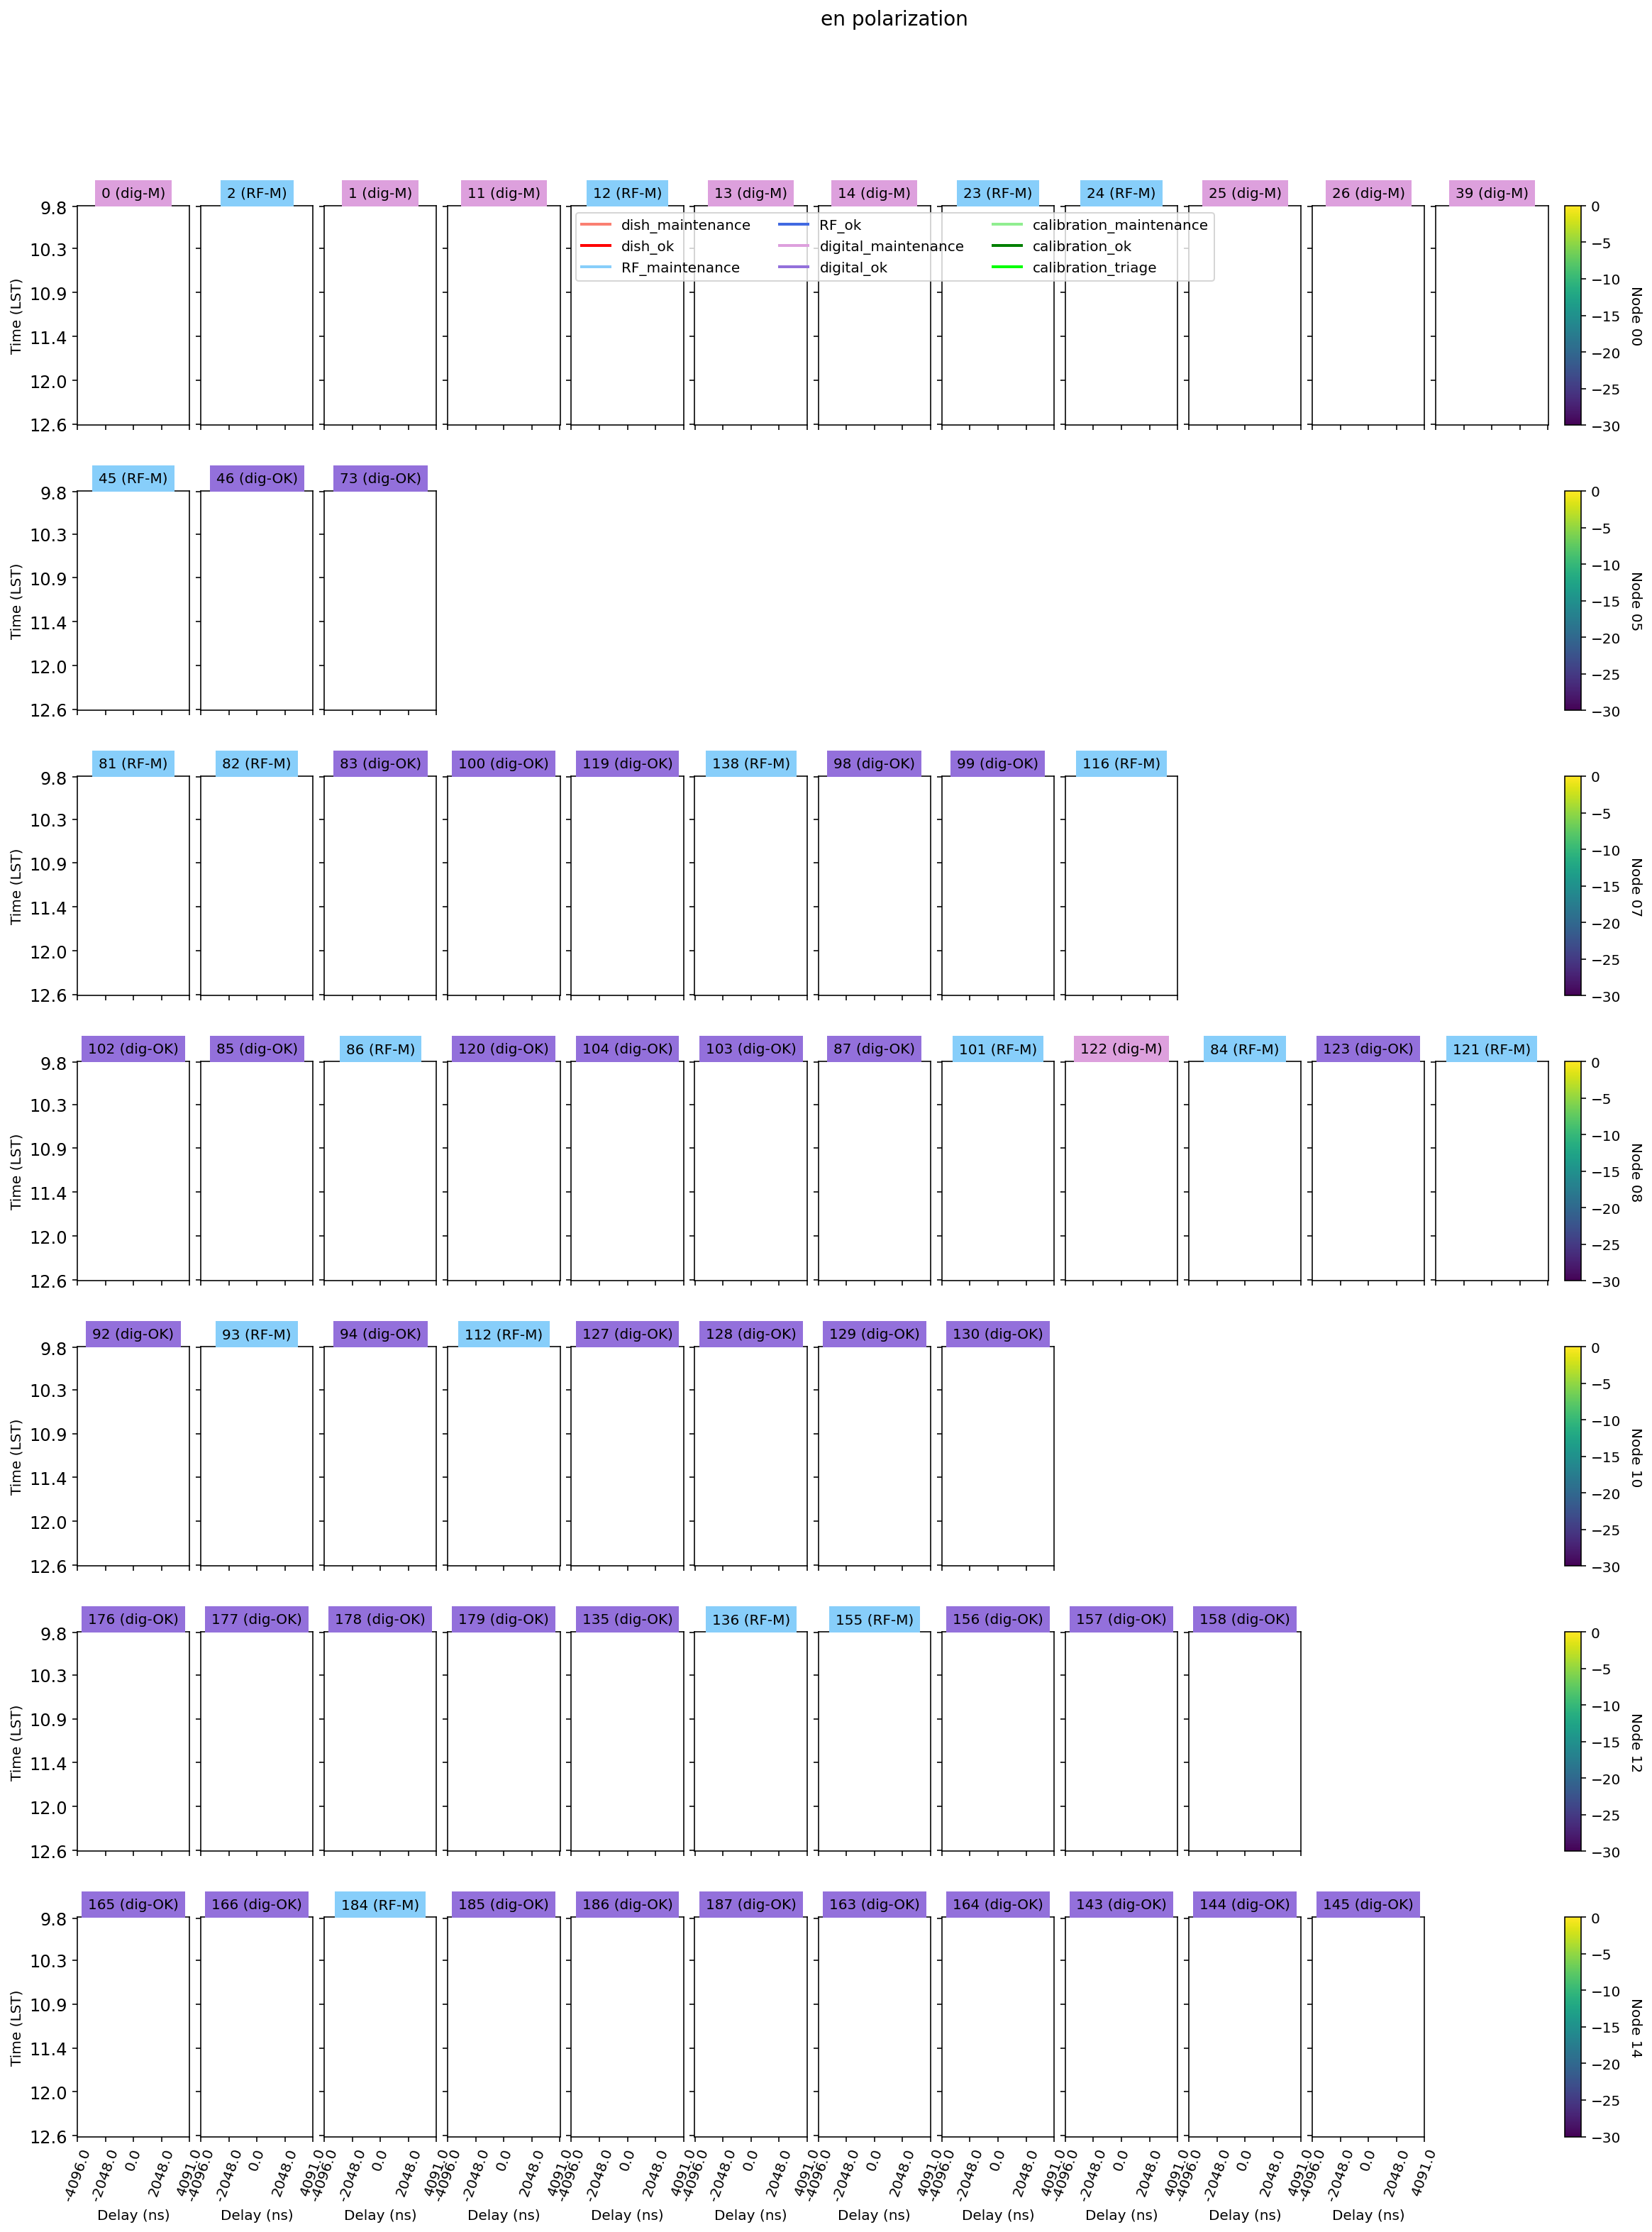

In [9]:
utils.plot_wfds(uvd, _data_cleaned_sq, 3)

## Analysis of 2700ns features from delay spectra

This plot shows the relative amplitude at 2700 ns feature. The relative amplitude is calculated in dB with the mean amplitude at 2500-3000 ns compared to the mean amplitude at 2000-2500 ns. Larger values of relative feature amplitude indicate higher probability of detecting the peak at 2700 ns. Antennas in the same node are grouped by the shaded region.

UnboundLocalError: local variable 'coloramp' referenced before assignment

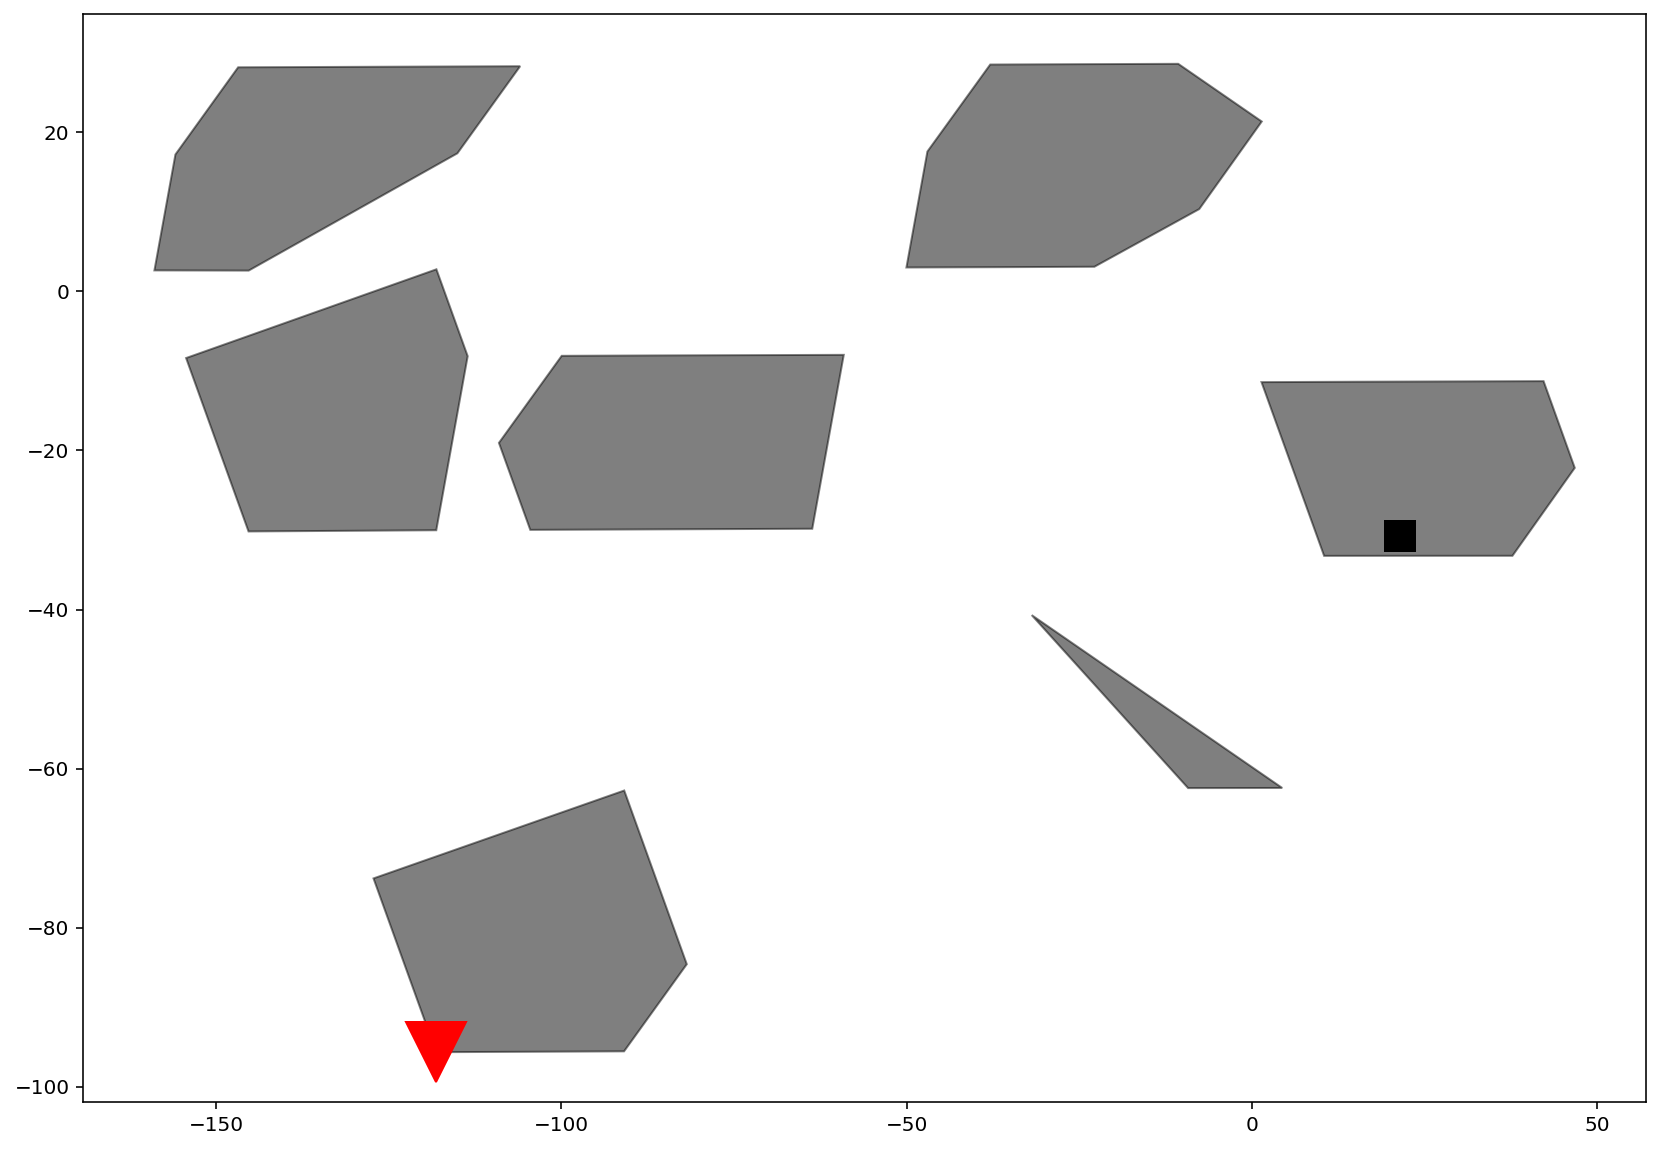

In [10]:
utils.plot_antFeatureMap(uvd, _data_cleaned_sq, JD, pol='nn')

UnboundLocalError: local variable 'coloramp' referenced before assignment

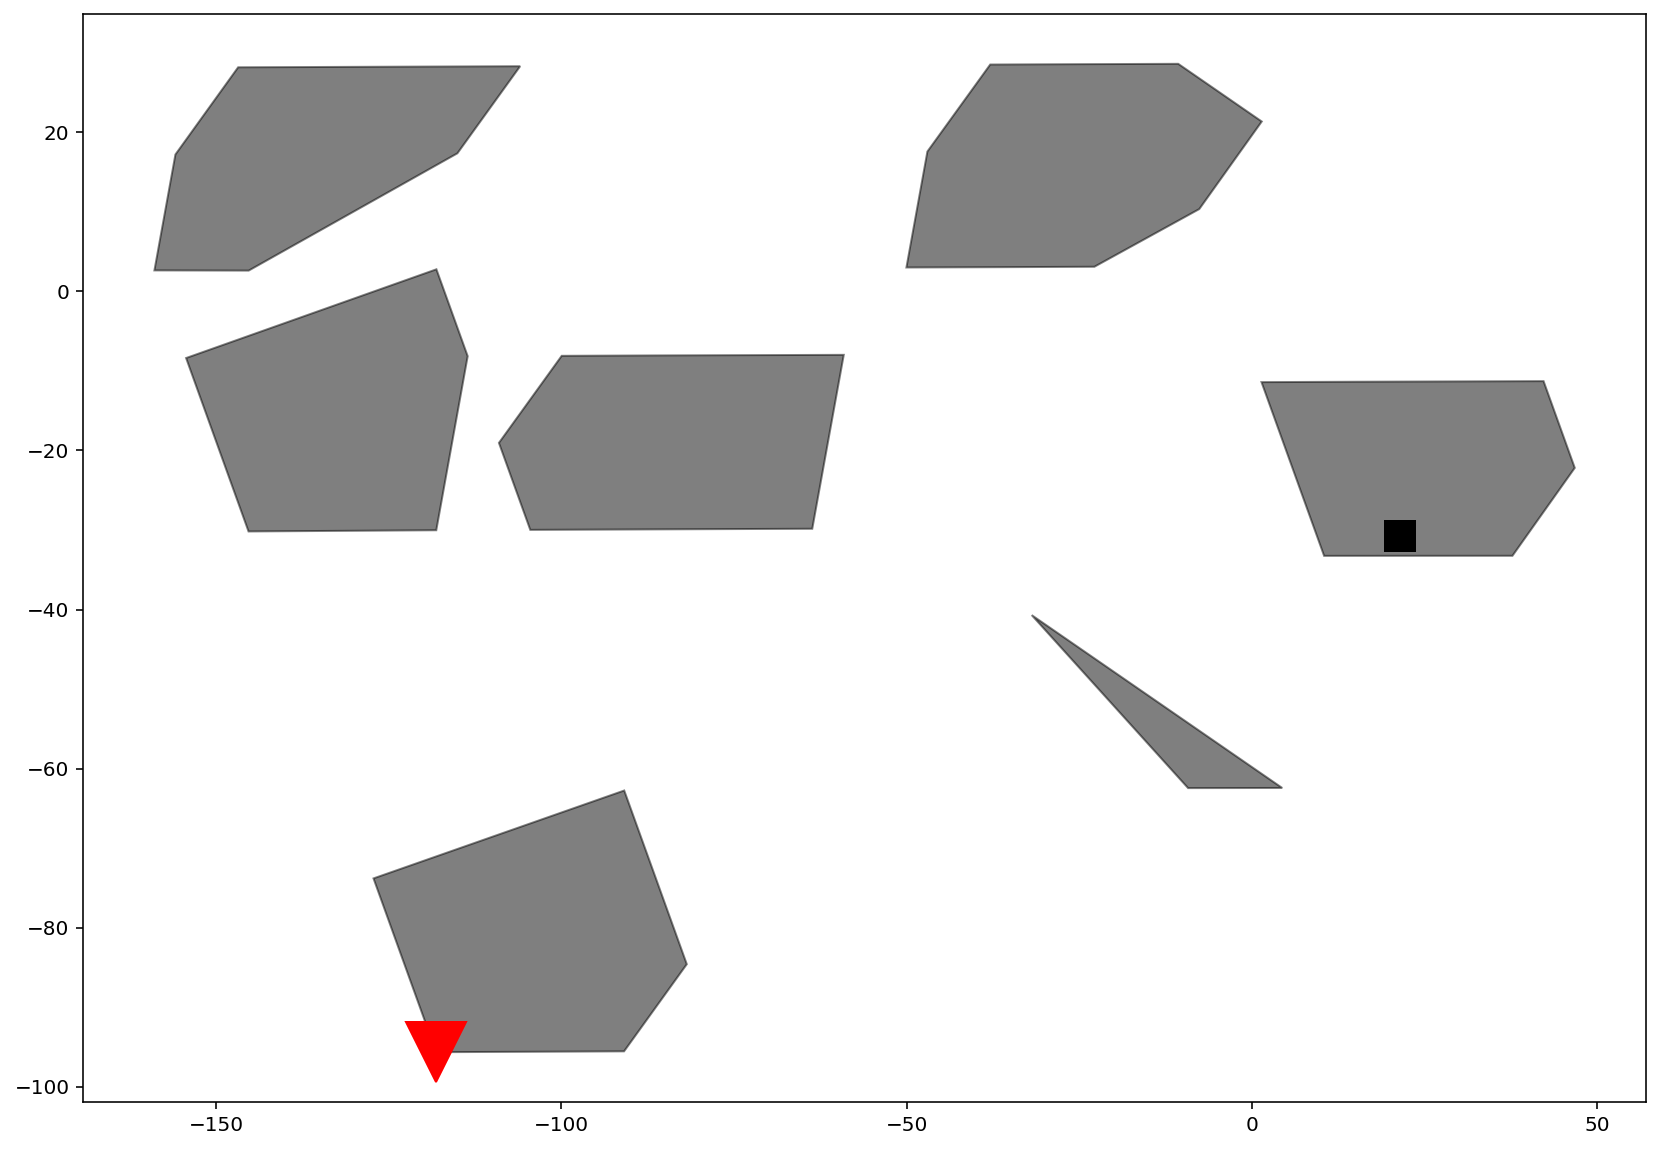

In [11]:
utils.plot_antFeatureMap(uvd, _data_cleaned_sq, JD, pol='ee')

This plot shows a matrix representing the 2700ns feature correlation of each baseline. The color bar indicates the amplitude of 2700ns (mean amplitude of 2500-3000ns delay spectrum) in dB which is the same as that in the above plot.

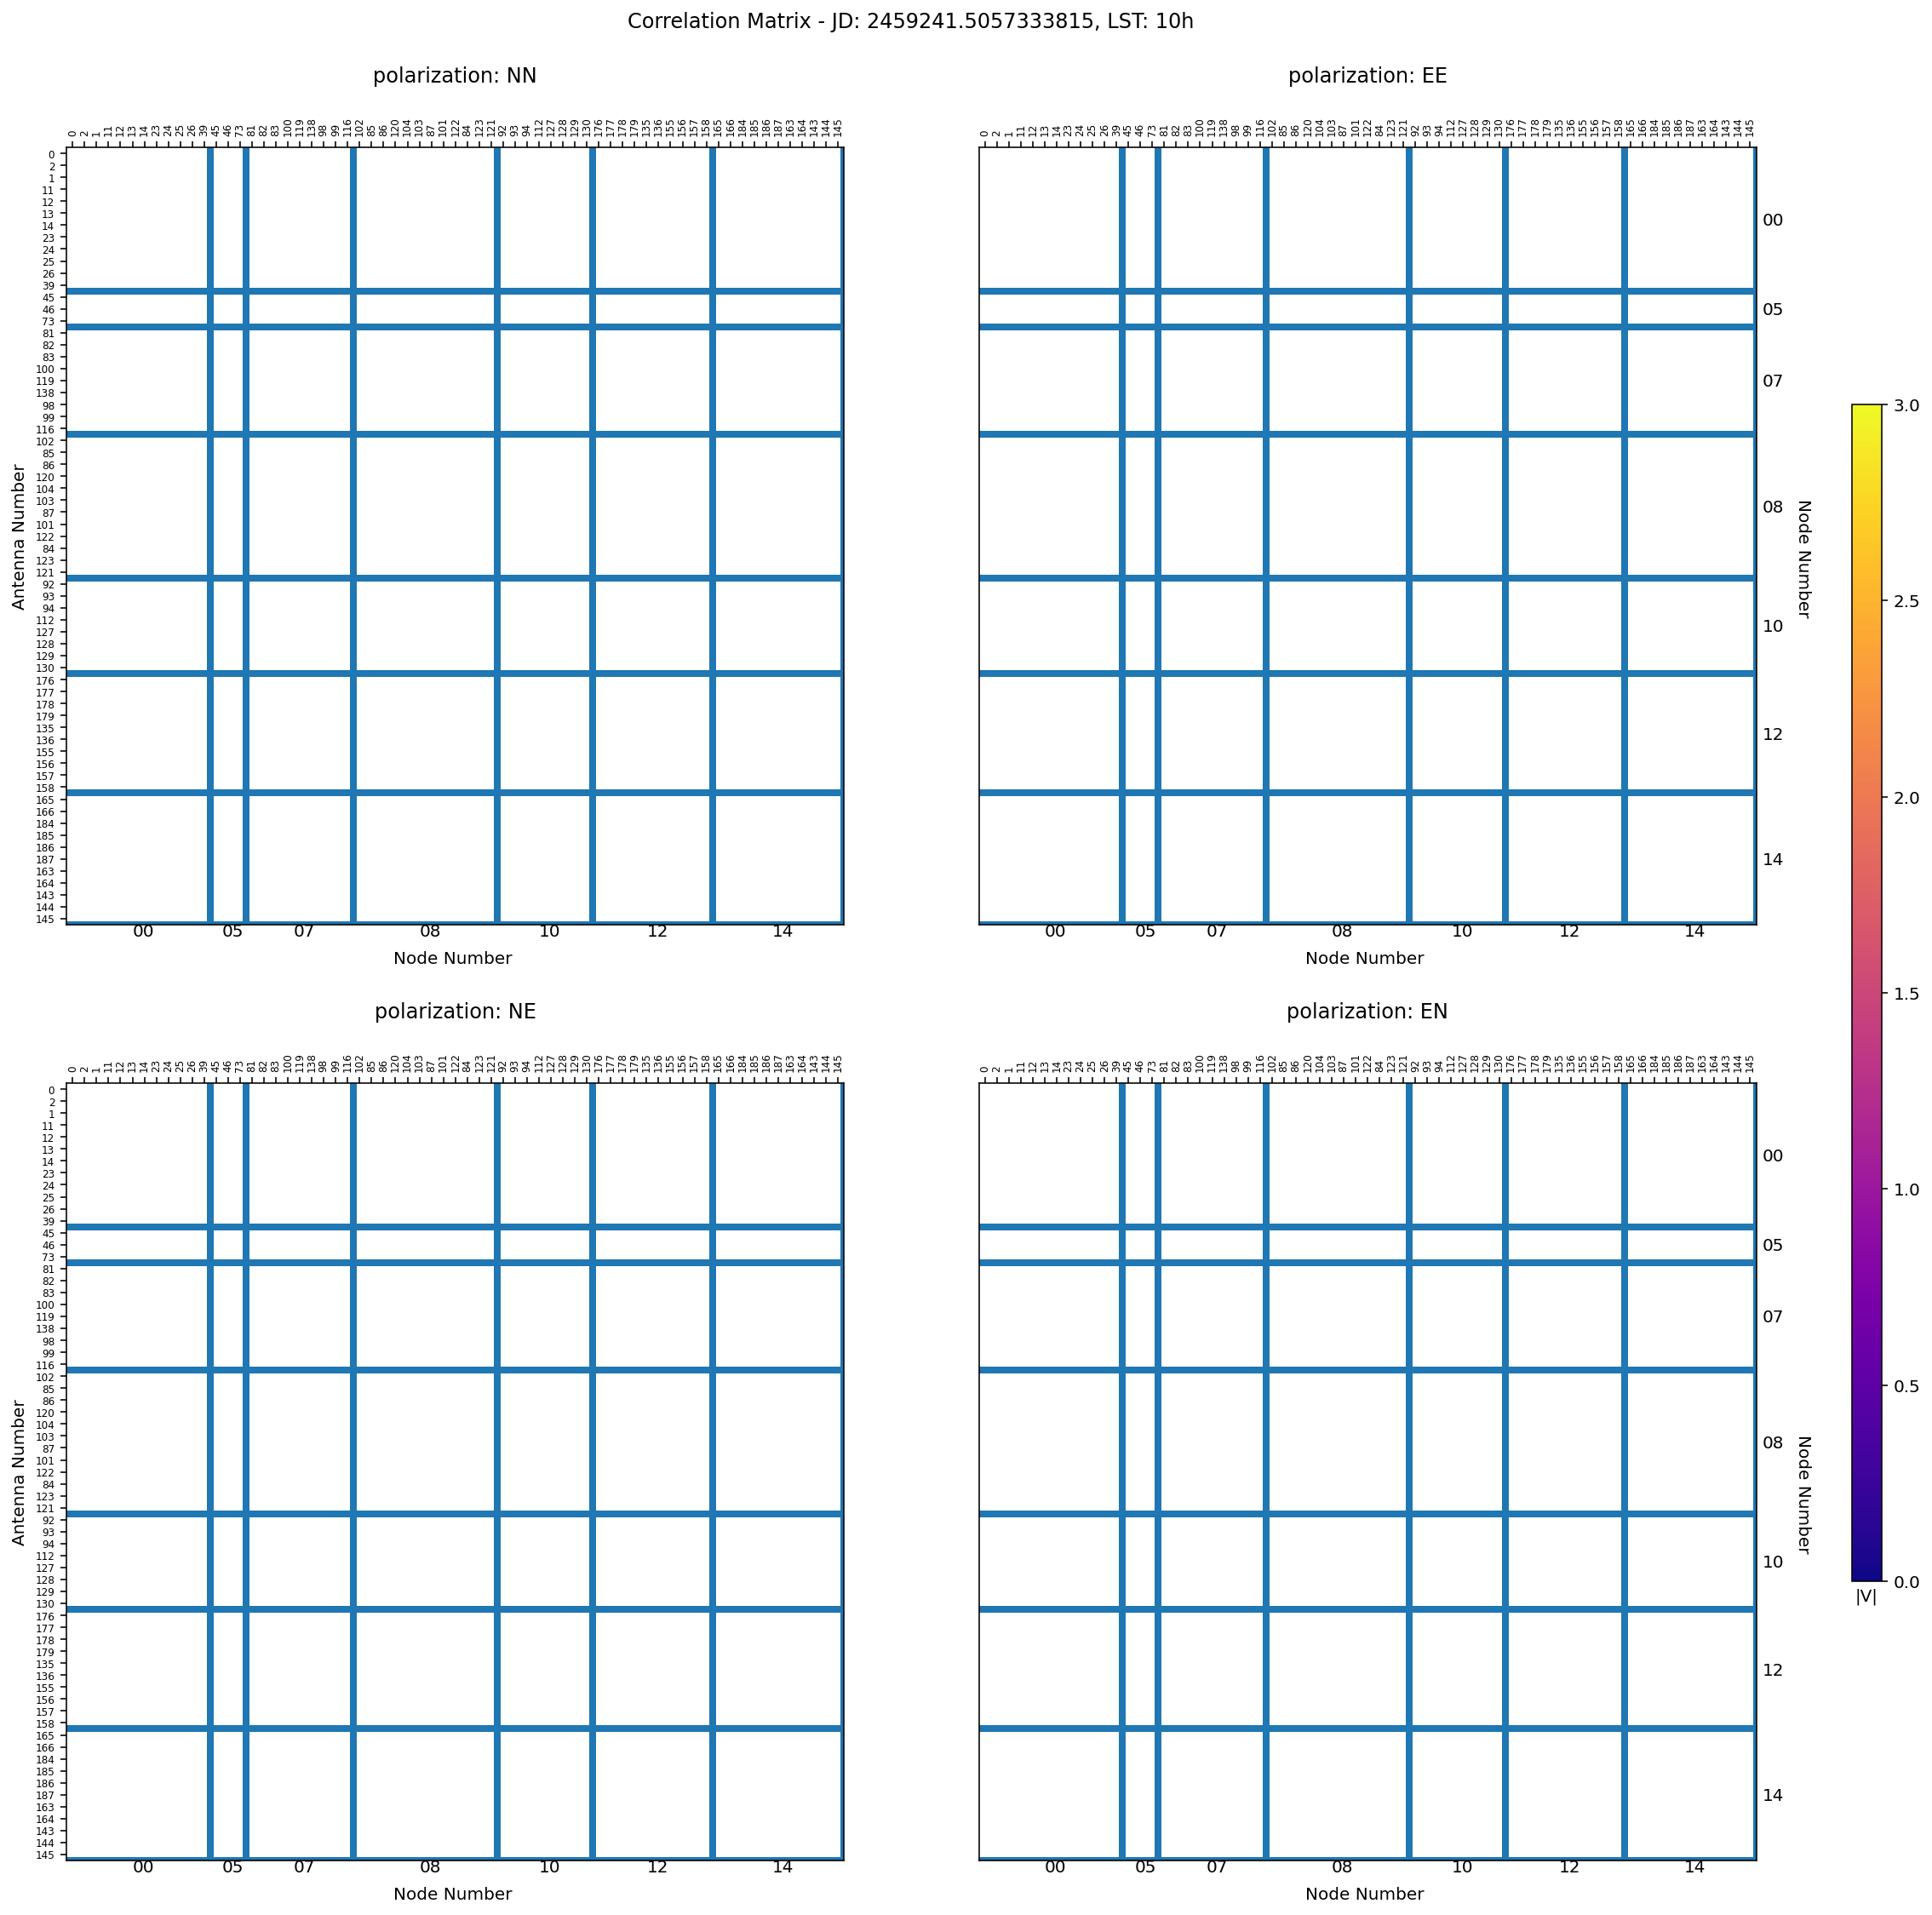

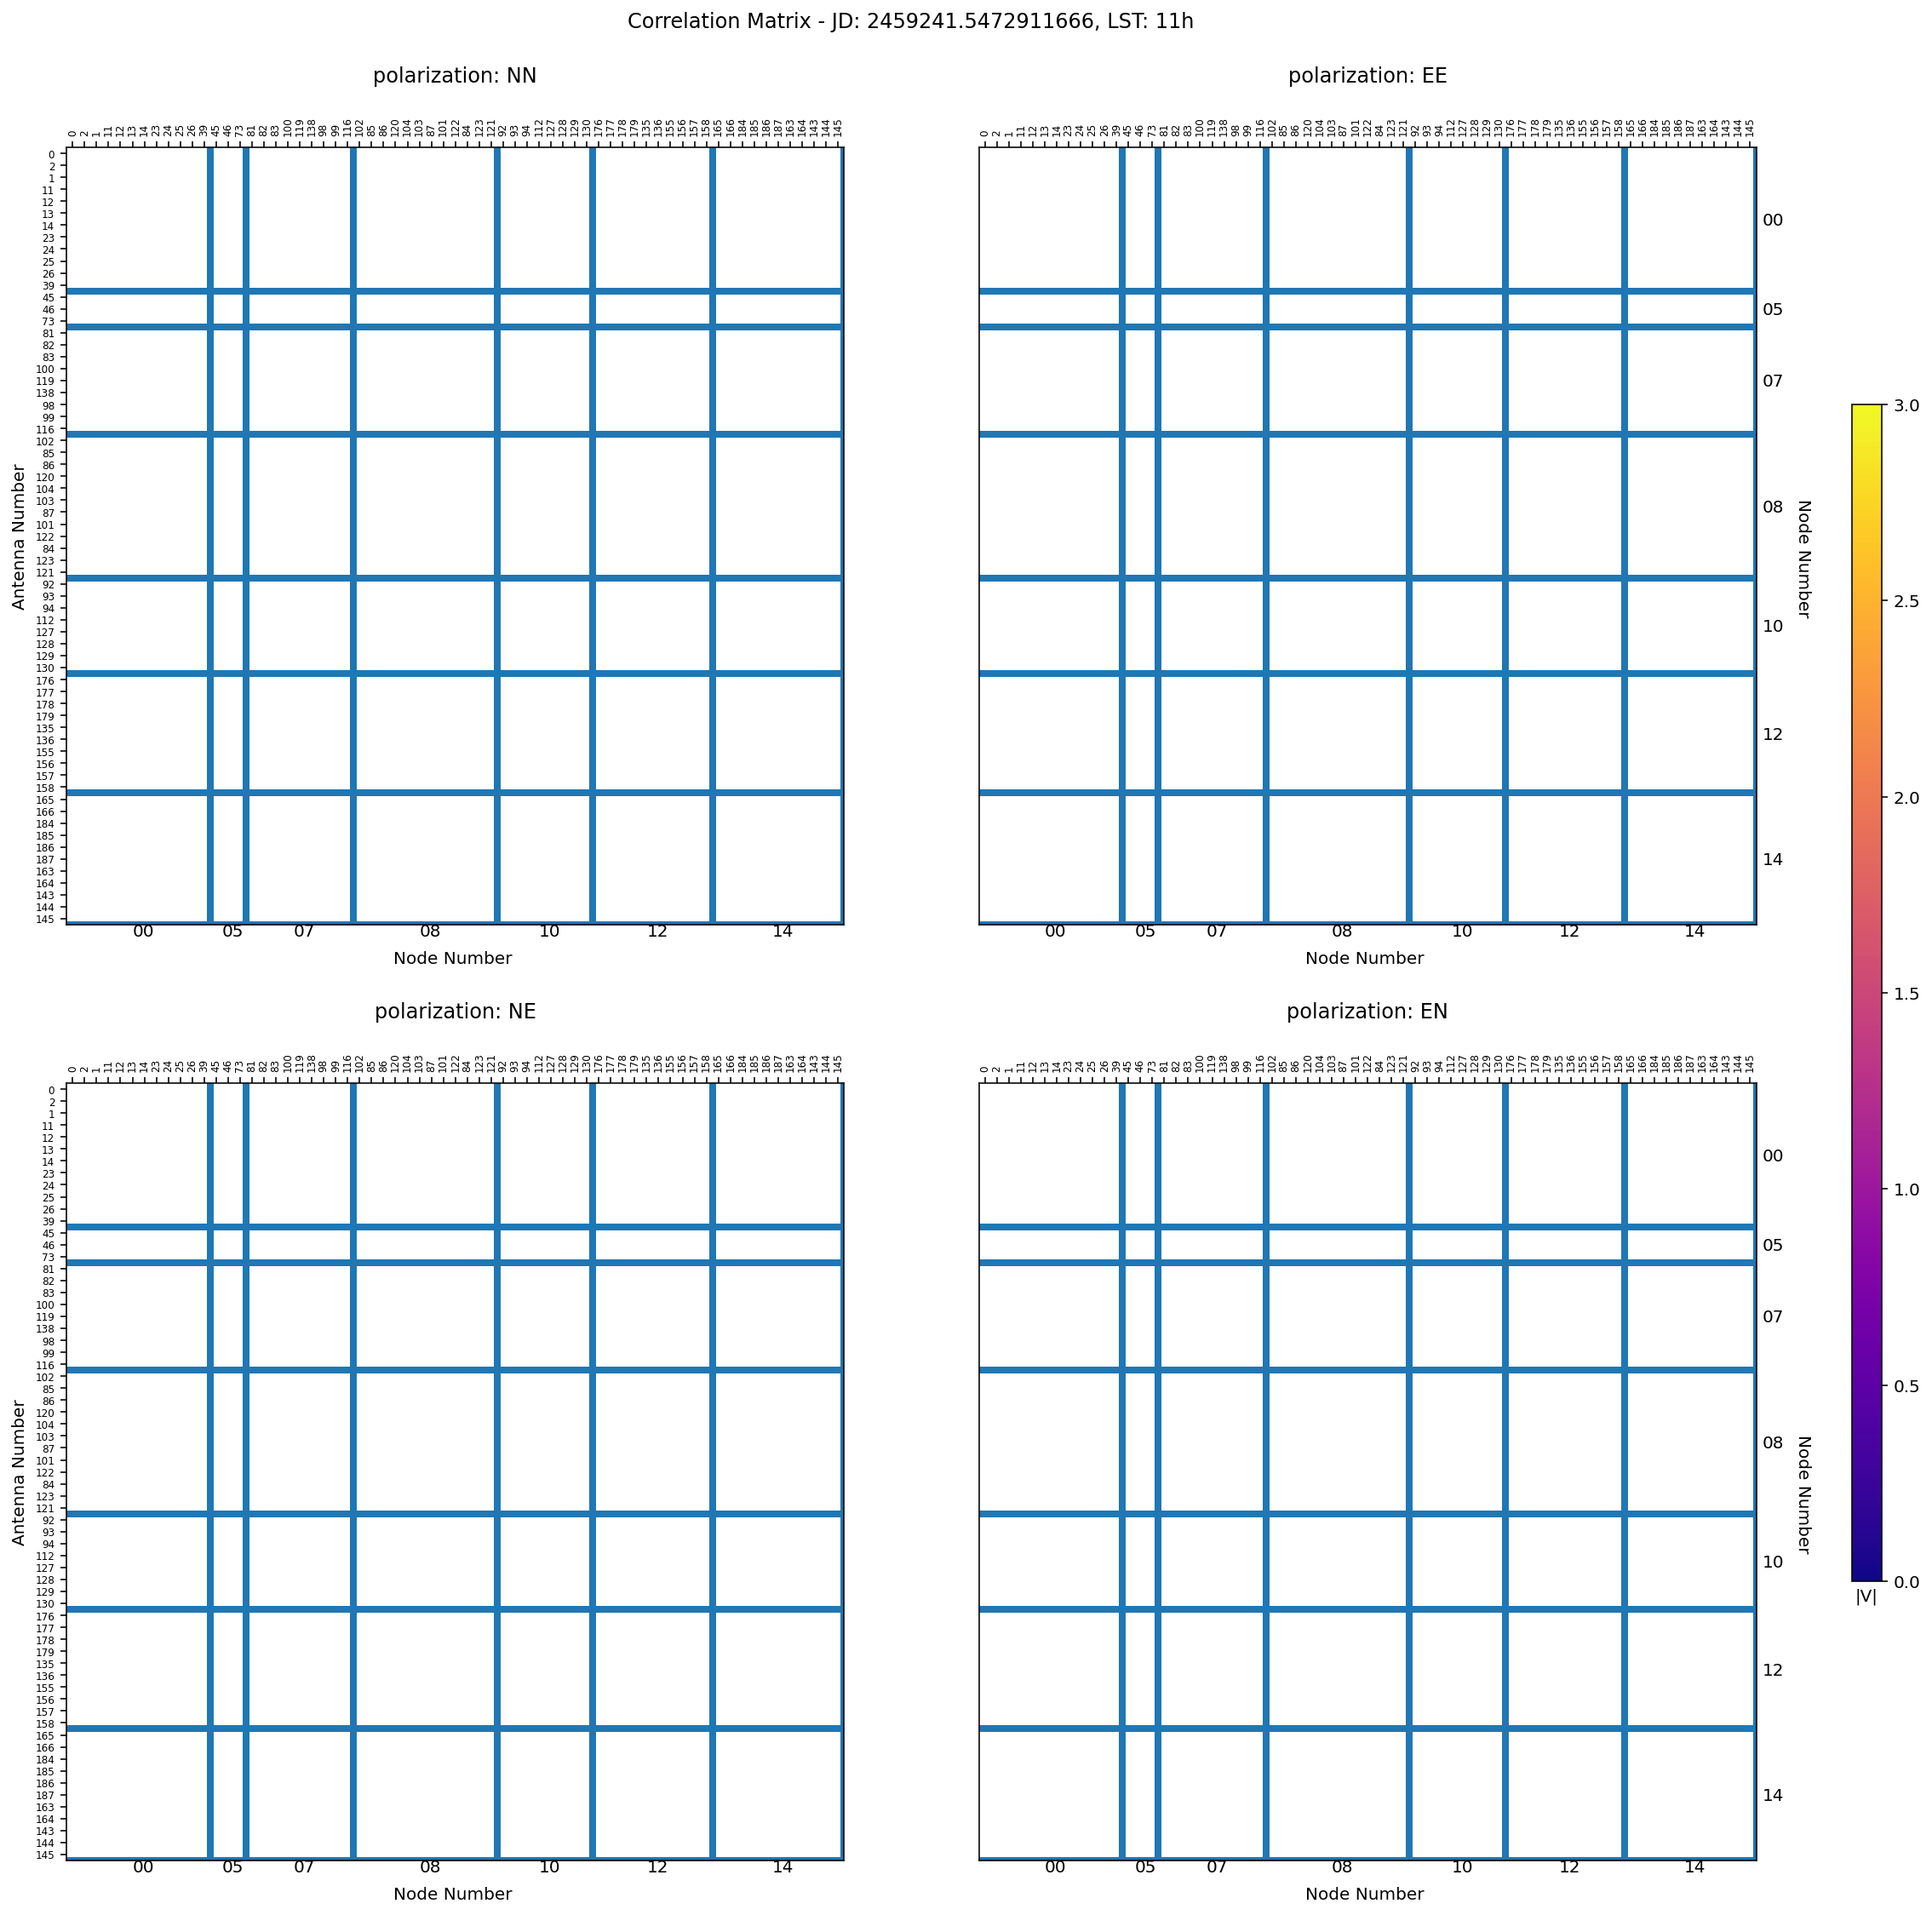

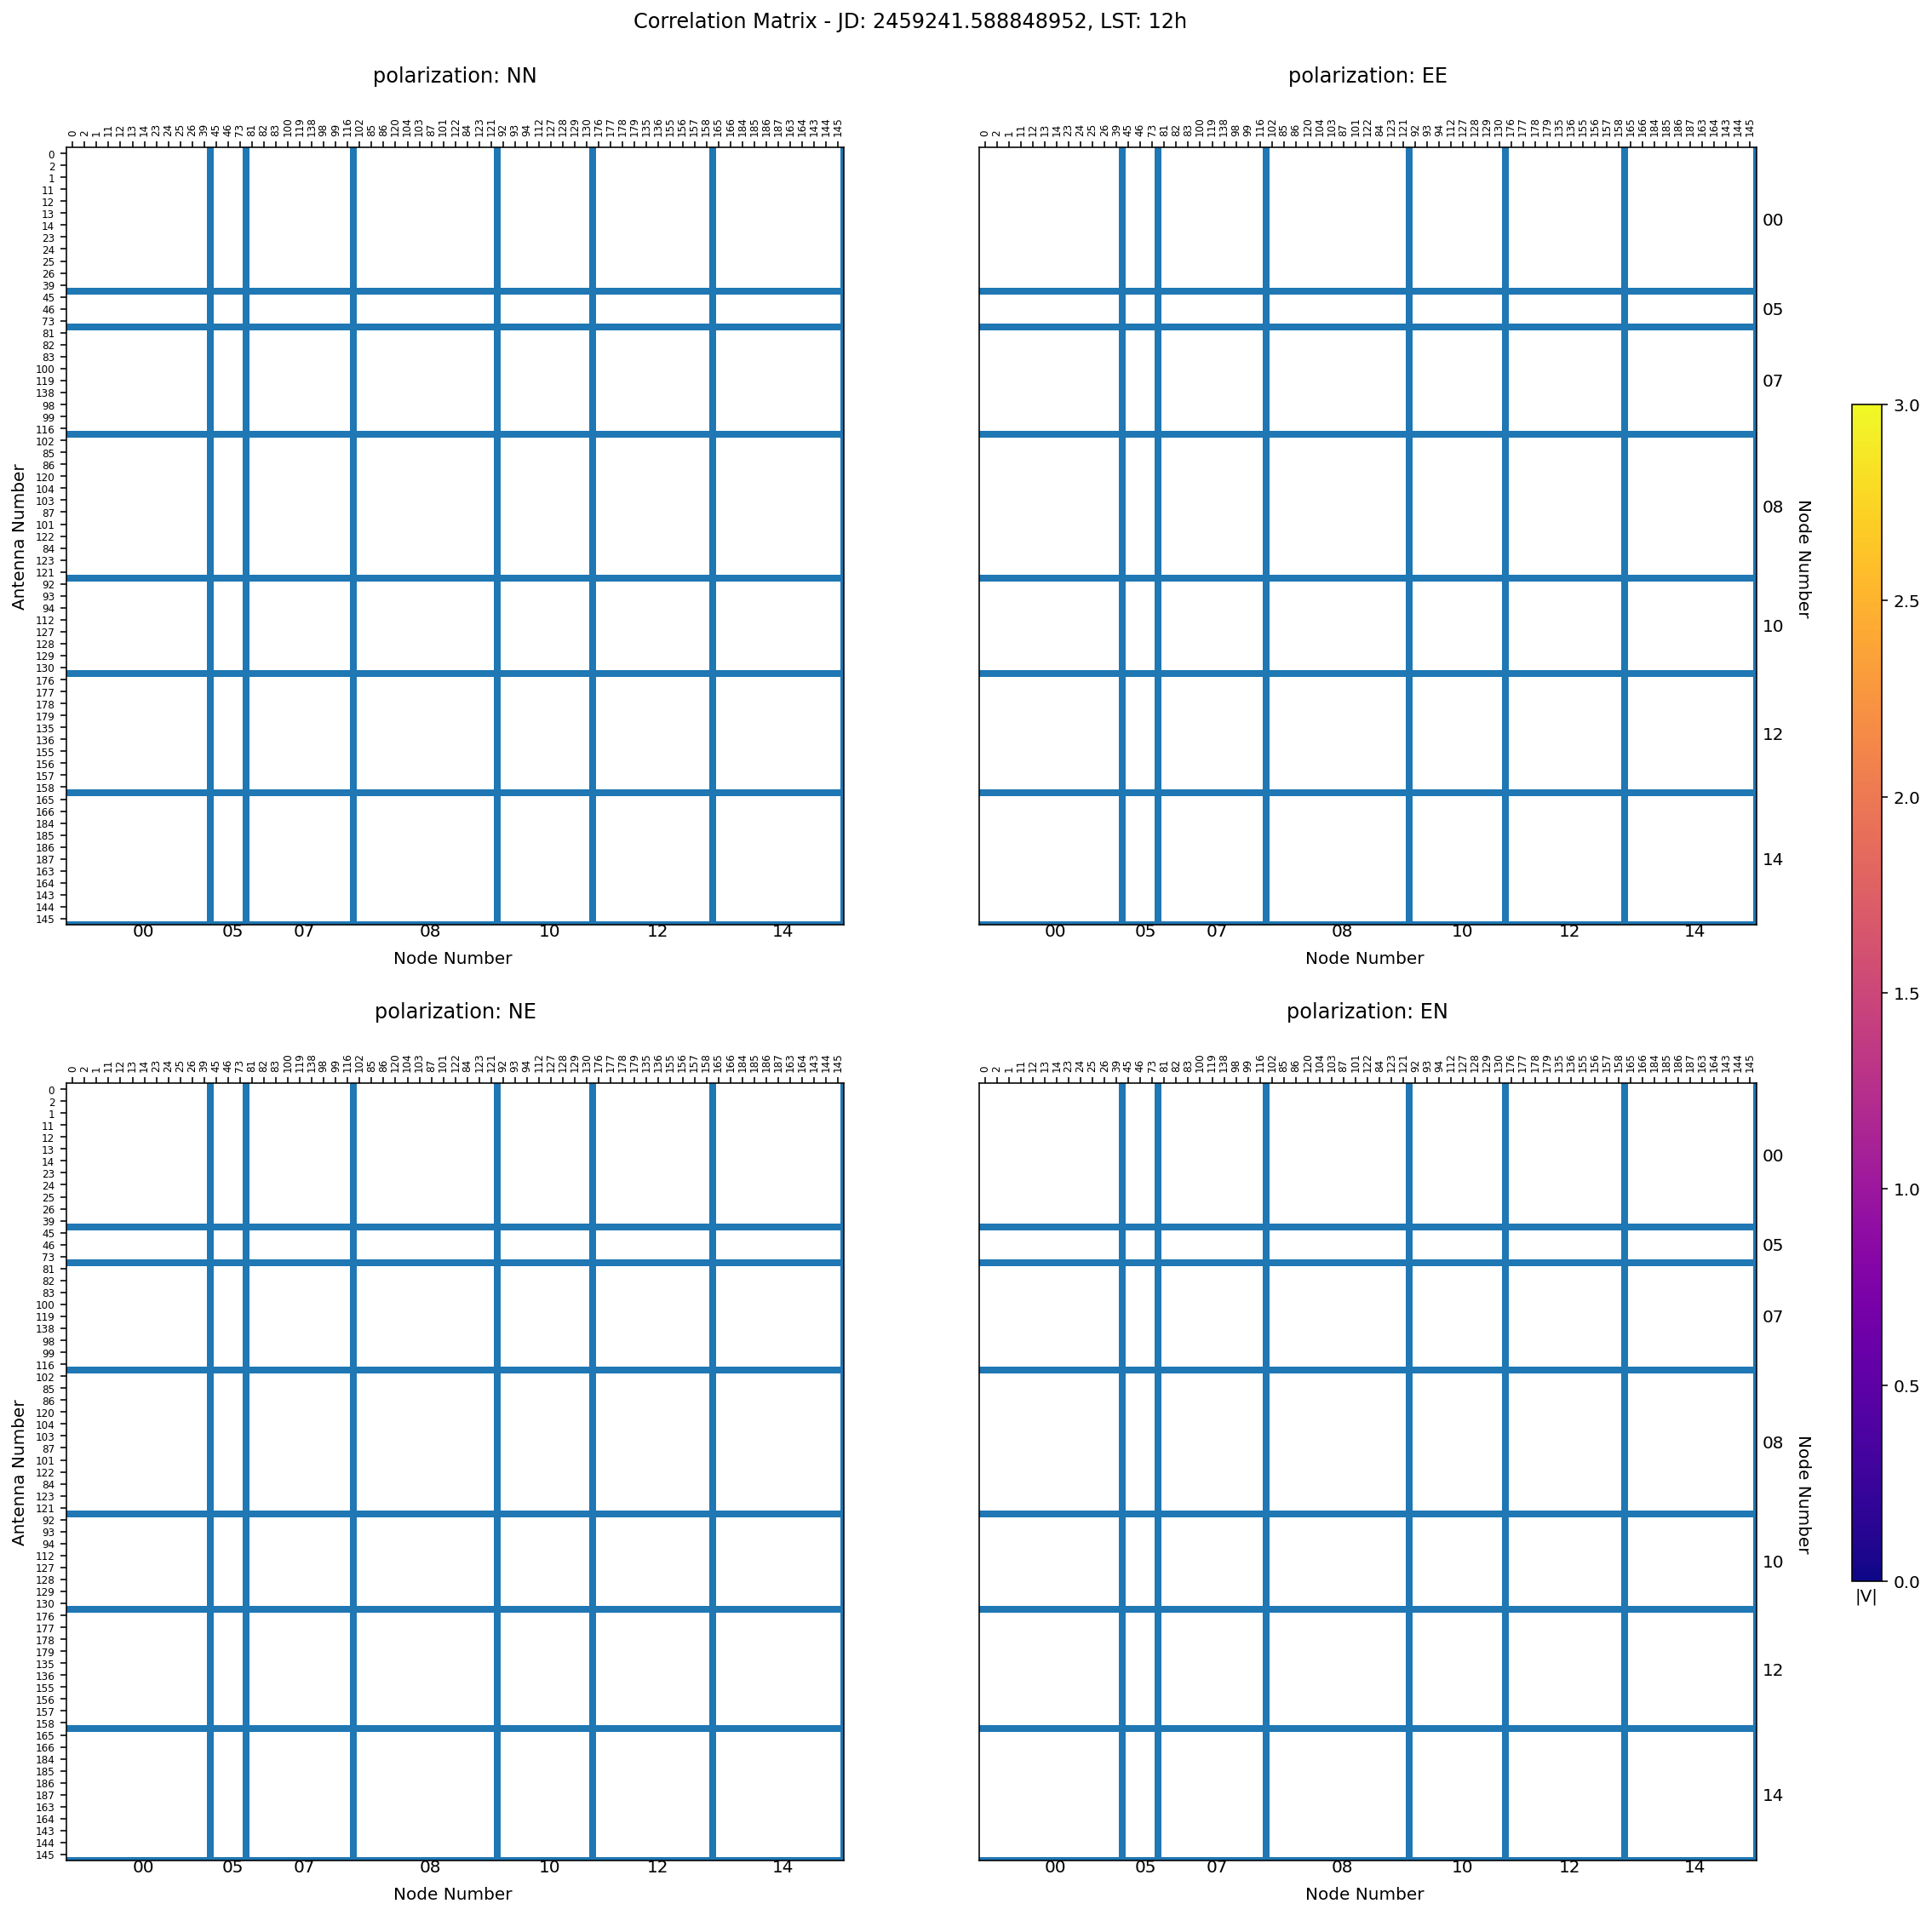

In [12]:
utils.CorrMatrix_2700ns(uvd, HHfiles, difffiles, flagfile, JD)

## HTML file for delay spectrum and autocorrelation plot is provided separately in the same directory

An HTML file which includes time-averaged delay spectra and autocorrelations for each antenna/pol is made in the directory of this notebook. Here is an explanation for the plots:

Left panel: time averaged delay spectum of autocorrelation (blue) and noise from diff file representing the expected variance of the delay spectrum (red) $\sqrt{\sigma_{\rm diff}^2/N_{\rm t}}$ where $N_{\rm t}$ is the number of time sample. Ideally, we expect the delay spectrum is consistent with the noise level at $\tau > \sim250$ns
    
Right panel: time averaged autocorrelations w/o (orange) and w/ xRFI flags (blue). Flagged one, which is used for making the delay spectrum, is shifted from the unflagged one for clarity

In [13]:
# html_filename = "delay_spectrum_JD{}.html".format(JD)
# utils.make_html_dspec(HHfiles[::10], html_filename, bls, uvd, uvd_diff, _data_cleaned_sq, data_rs_sq, JD)